In [29]:
import numpy as np
import xarray as xr
import salishsea_tools.river_202108 as rivers
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal

In [3]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [61]:
fw_rivers_fraser = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20120101_20140101.nc')
fw_rivers_subset = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_subset_all_20120101_20140101.nc')
fw_rivers_other = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_other_all_20120101_20140101.nc')
fw_rivers_nooksack = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_one_nooksack_all_20120101_20160101.nc')

# time = fw_rivers_fraser['time'].to_numpy()
fraser_file = '1d_hindcast_volume_fraser_river_s2012_732_dep_0_40.csv'
fraser_arr = pd.read_csv('dye_to_vol/' + fraser_file)['0'].to_numpy()

nooksack_file = '1d_hindcast_volume_nooksack_river_s2012_1462_dep_0_40.csv'
nooksack_arr = pd.read_csv('dye_to_vol/' + nooksack_file)['0'].to_numpy()

skagit_file = '1d_hindcast_volume_skagit_river_s2012_1462_dep_0_40.csv'
skagit_arr = pd.read_csv('dye_to_vol/' + skagit_file)['0'].to_numpy()

snohomish_file = '1d_hindcast_volume_snohomish_river_s2012_1462_dep_0_40.csv'
snohomish_arr = pd.read_csv('dye_to_vol/' + snohomish_file)['0'].to_numpy()

nisqually_file = '1d_hindcast_volume_nisqually_river_s2012_1462_dep_0_40.csv'
nisqually_arr = pd.read_csv('dye_to_vol/' + nisqually_file)['0'].to_numpy()

elwha_file = '1d_hindcast_volume_elwha_river_s2012_1462_dep_0_40.csv'
elwha_arr = pd.read_csv('dye_to_vol/' + elwha_file)['0'].to_numpy()

cowichan_file = '1d_hindcast_volume_cowichan_river_s2012_1462_dep_0_40.csv'
cowichan_arr = pd.read_csv('dye_to_vol/' + cowichan_file)['0'].to_numpy()

nanaimo_file = '1d_hindcast_volume_nanaimo_river_s2012_1462_dep_0_40.csv'
nanaimo_arr = pd.read_csv('dye_to_vol/' + nanaimo_file)['0'].to_numpy()

puntledge_file = '1d_hindcast_volume_puntledge_river_s2012_1462_dep_0_40.csv'
puntledge_arr = pd.read_csv('dye_to_vol/' + puntledge_file)['0'].to_numpy()

salmon_file = '1d_hindcast_volume_salmon_river_s2012_732_dep_0_40.csv'
salmon_arr = pd.read_csv('dye_to_vol/' + salmon_file)['0'].to_numpy()

homathko_file = '1d_hindcast_volume_homathko_river_s2012_732_dep_0_40.csv'
homathko_arr = pd.read_csv('dye_to_vol/' + homathko_file)['0'].to_numpy()

squamish_file = '1d_hindcast_volume_squamish_river_s2012_732_dep_0_40.csv'
squamish_arr = pd.read_csv('dye_to_vol/' + squamish_file)['0'].to_numpy()

In [45]:
Fraser_mod = pd.read_csv('river_dailies_to_ts_Fraser_20120101_20150101.csv')
Fraser_mod['date'] = pd.to_datetime(Fraser_mod['date'], format='%m-%d-%Y')

rho = 1026
runoff_to_m3 = 86400 * (500*440)/rho

color1 = '#4f8cf0'
color2 = '#162845'
color3 = '#345d9e'

In [39]:
# Sampling frequency (once per day)
Fs = 1  # Samples per day
# Nyquist frequency
Fn = Fs / 2
# Cutoff frequency (less than once per year)
Fc = 0.5 / 365  # Frequency in Hz
# Design a low-pass filter
order = 4  # Filter order
b, a = signal.butter(order, Fc / Fn, 'low')

## Exponential Fits

In [8]:
def days_vols(idxs, ds, arr):
    days = [ds['time'][idxs[0]], ds['time'][idxs[1]], ds['time'][idxs[2]]]
    vols = [arr[idxs[0]], arr[idxs[1]], arr[idxs[2]]]
    return days, vols

In [9]:
def resample_mean(arr, chunk_size):
    if len(arr) % chunk_size != 0:
        raise ValueError("Array length must be divisible by chunk size")

    num_chunks = len(arr) // chunk_size
    return np.mean(arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size), axis=1)

In [10]:
def model(t, A, T):
    return A * (1 - np.exp(-t / T))

In [11]:
def model_inv(y, A, T):
    return -T * np.log(1 - (y/A))

In [12]:
def fit_and_plot(initial_guess, t_data, Y_data, region):
    popt, pcov = curve_fit(model, t_data, Y_data, p0=initial_guess)
    A_opt, T_opt = popt

    T_80pct = model_inv(A_opt*0.8, A_opt, T_opt)
    T_90pct = model_inv(A_opt*0.9, A_opt, T_opt)
    T_95pct = model_inv(A_opt*0.95, A_opt, T_opt)
    T_99pct = model_inv(A_opt*0.99, A_opt, T_opt)

    print("Optimized parameters:")
    print("A = {:.0f} m^3".format(A_opt))
    print("T = {:.0f} days, {:.2f} years".format(T_opt, T_opt/365))
    print('T_80pct = {:.2f} years'.format(T_80pct/365))
    print('T_90pct = {:.2f} years'.format(T_90pct/365))
    print('T_95pct = {:.2f} years'.format(T_95pct/365))
    print('T_99pct = {:.2f} years'.format(T_99pct/365))

    # Generate the fitted curve
    t_fit = np.linspace(0, max(t_data)*2, 100)
    Y_fit = model(t_fit, A_opt, T_opt)

    # Plot the original data and the fitted curve
    plt.plot(t_data, Y_data, 'bo', label='Data')
    plt.plot(t_fit, Y_fit, 'r-', label='Fitted curve')
    plt.vlines([T_opt, T_80pct, T_90pct, T_95pct, T_99pct], [0, 0, 0, 0, 0], [A_opt, A_opt, A_opt, A_opt, A_opt], 'k', linestyle='--', alpha=0.5)
    plt.xlabel('t: Days since start of run')
    plt.ylabel(r'Y: $m^3$ freshwater')
    plt.legend()
    plt.title('{} Exponential Fit'.format(region))
    plt.show()

    return A_opt, T_opt

In [13]:
idxs = [0, 366, 731]

In [14]:
np.arange(0, len(fraser_arr), 183)+(183/2)

array([ 91.5, 274.5, 457.5, 640.5])

Optimized parameters:
A = 65977131694 m^3
T = 289 days, 0.79 years
T_80pct = 1.27 years
T_90pct = 1.82 years
T_95pct = 2.37 years
T_99pct = 3.65 years


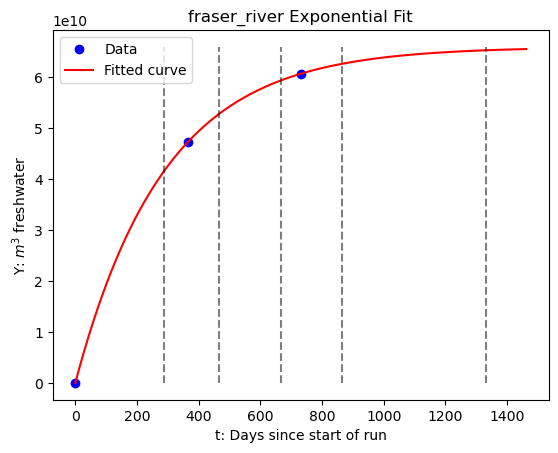

Optimized parameters:
A = 71270247474 m^3
T = 265 days, 0.73 years
T_80pct = 1.17 years
T_90pct = 1.67 years
T_95pct = 2.18 years
T_99pct = 3.34 years


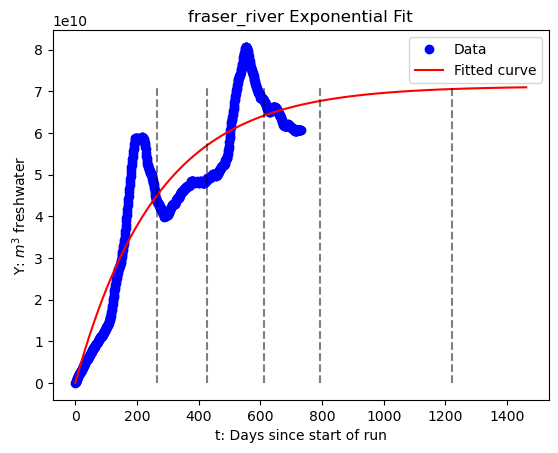

Optimized parameters:
A = 75444083911 m^3
T = 309 days, 0.85 years
T_80pct = 1.36 years
T_90pct = 1.95 years
T_95pct = 2.53 years
T_99pct = 3.90 years


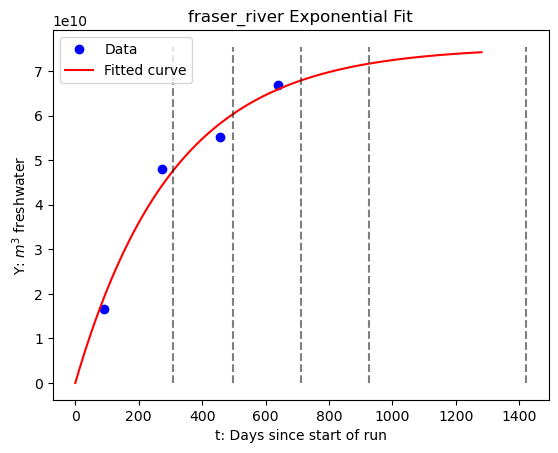

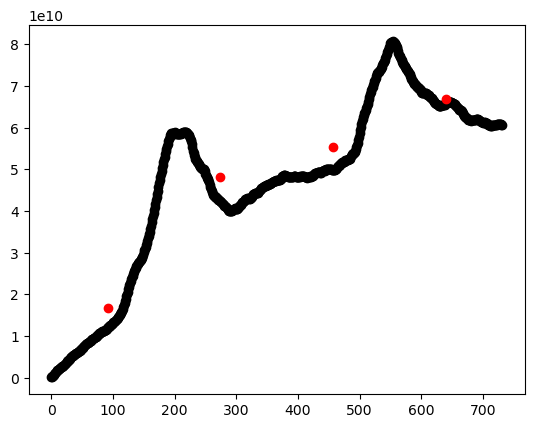

In [15]:
variable = 'fraser_river'
days, vols = days_vols(idxs, fw_rivers_fraser, fraser_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(fraser_arr)), Y_data=fraser_arr, region=variable)

resample_data = resample_mean(fraser_arr, 183)
A_opt_fraser, T_opt_fraser = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(fraser_arr), 183)+(183/2), Y_data=resample_data, region=variable)

plt.plot(np.arange(0, len(fraser_arr)), fraser_arr, 'ko')
plt.plot(np.arange(0, len(fraser_arr), 183)+(183/2), resample_data, 'ro')

Optimized parameters:
A = 322329121 m^3
T = 193 days, 0.53 years
T_80pct = 0.85 years
T_90pct = 1.21 years
T_95pct = 1.58 years
T_99pct = 2.43 years


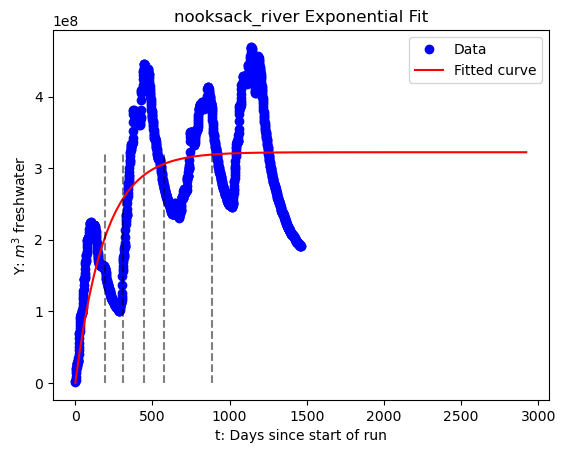

Optimized parameters:
A = 335498675 m^3
T = 251 days, 0.69 years
T_80pct = 1.11 years
T_90pct = 1.58 years
T_95pct = 2.06 years
T_99pct = 3.17 years


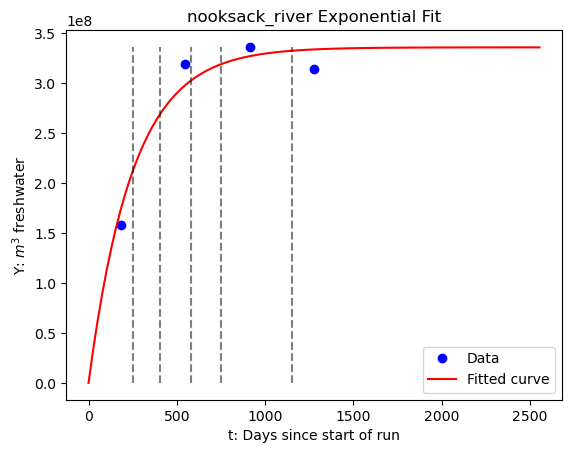

Optimized parameters:
A = 353747709 m^3
T = 257 days, 0.71 years
T_80pct = 1.14 years
T_90pct = 1.62 years
T_95pct = 2.11 years
T_99pct = 3.25 years


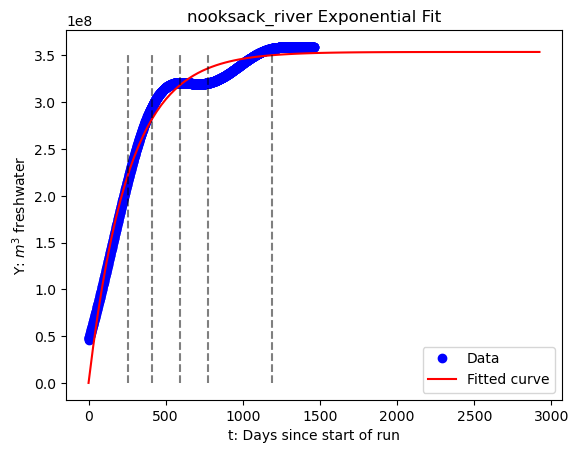

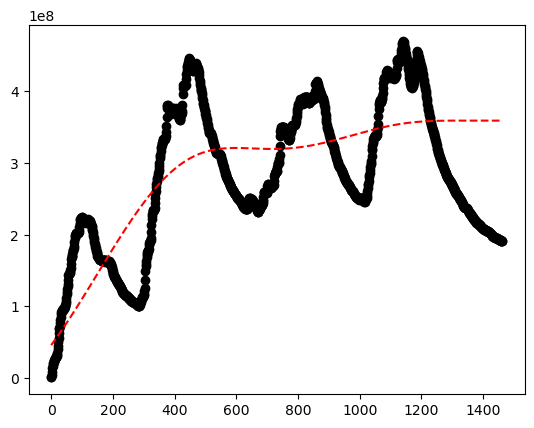

In [42]:
variable = 'nooksack_river'
days, vols = days_vols(idxs, fw_rivers_subset, nooksack_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nooksack_arr)), Y_data=nooksack_arr, region=variable)

chunk_size = 365
data_arr = nooksack_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, nooksack_arr)
A_opt_nooksack, T_opt_nooksack = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nooksack_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(nooksack_arr)), nooksack_arr, 'ko')
plt.plot(np.arange(0, len(nooksack_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 3581627022 m^3
T = 218 days, 0.60 years
T_80pct = 0.96 years
T_90pct = 1.37 years
T_95pct = 1.79 years
T_99pct = 2.75 years


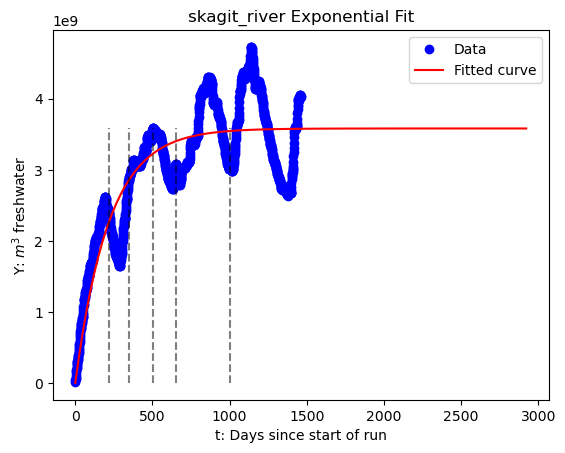

Optimized parameters:
A = 3671199311 m^3
T = 263 days, 0.72 years
T_80pct = 1.16 years
T_90pct = 1.66 years
T_95pct = 2.16 years
T_99pct = 3.32 years


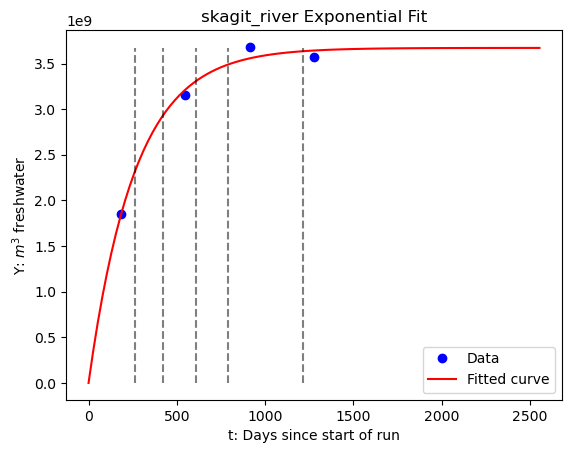

Optimized parameters:
A = 3832231543 m^3
T = 280 days, 0.77 years
T_80pct = 1.23 years
T_90pct = 1.77 years
T_95pct = 2.30 years
T_99pct = 3.53 years


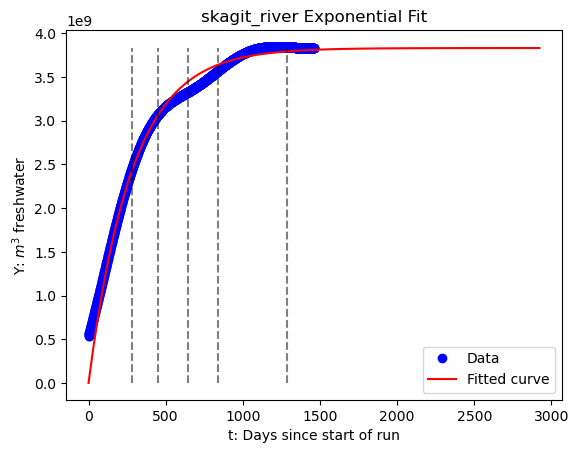

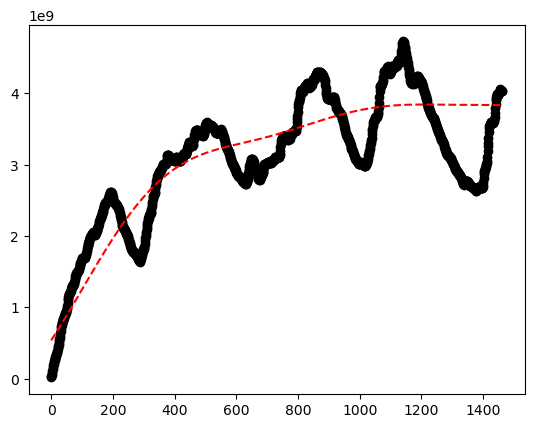

In [44]:
variable = 'skagit_river'
days, vols = days_vols(idxs, fw_rivers_subset, skagit_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(skagit_arr)), Y_data=skagit_arr, region=variable)

chunk_size = 365
data_arr = skagit_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, skagit_arr)
A_opt_skagit, T_opt_skagit = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(skagit_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(skagit_arr)), skagit_arr, 'ko')
plt.plot(np.arange(0, len(skagit_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 5261514271 m^3
T = 216 days, 0.59 years
T_80pct = 0.95 years
T_90pct = 1.36 years
T_95pct = 1.77 years
T_99pct = 2.73 years


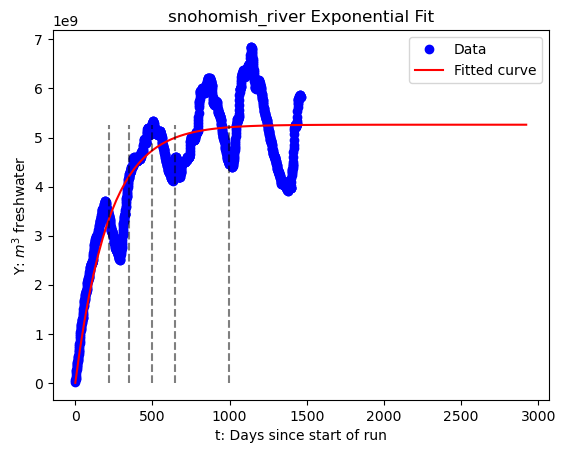

/tmp/ipykernel_2164749/3982814335.py:2: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(-t / T))


Optimized parameters:
A = 5387273905 m^3
T = 261 days, 0.72 years
T_80pct = 1.15 years
T_90pct = 1.65 years
T_95pct = 2.14 years
T_99pct = 3.29 years


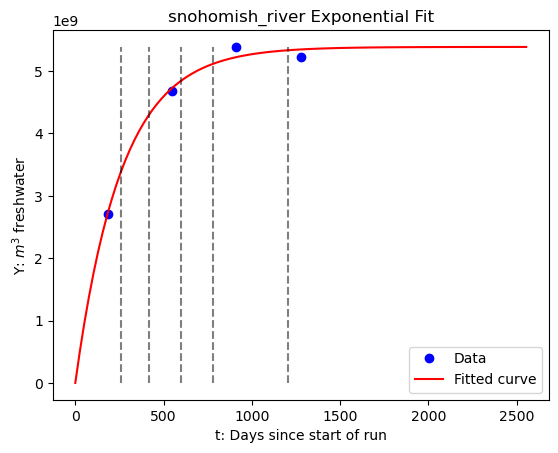

Optimized parameters:
A = 5599838576 m^3
T = 273 days, 0.75 years
T_80pct = 1.20 years
T_90pct = 1.72 years
T_95pct = 2.24 years
T_99pct = 3.45 years


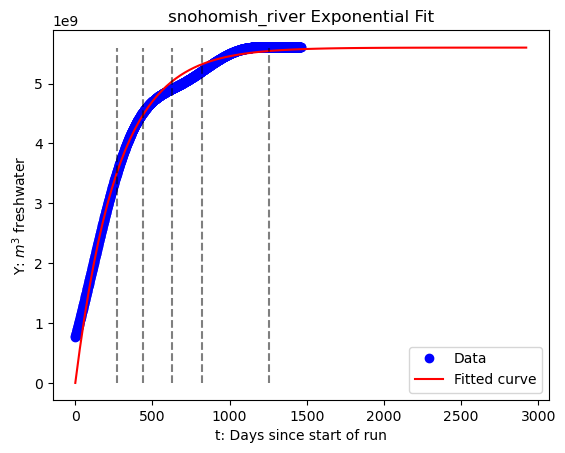

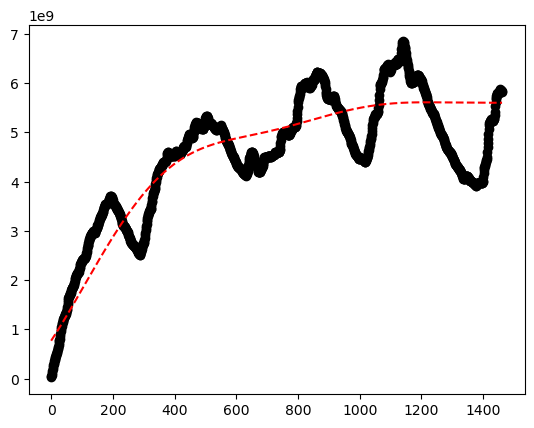

In [54]:
variable = 'snohomish_river'
days, vols = days_vols(idxs, fw_rivers_subset, snohomish_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(snohomish_arr)), Y_data=snohomish_arr, region=variable)

chunk_size = 365
data_arr = snohomish_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, snohomish_arr)
A_opt_snohomish, T_opt_snohomish = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(snohomish_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(snohomish_arr)), snohomish_arr, 'ko')
plt.plot(np.arange(0, len(snohomish_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 2025276739 m^3
T = 200 days, 0.55 years
T_80pct = 0.88 years
T_90pct = 1.26 years
T_95pct = 1.64 years
T_99pct = 2.52 years


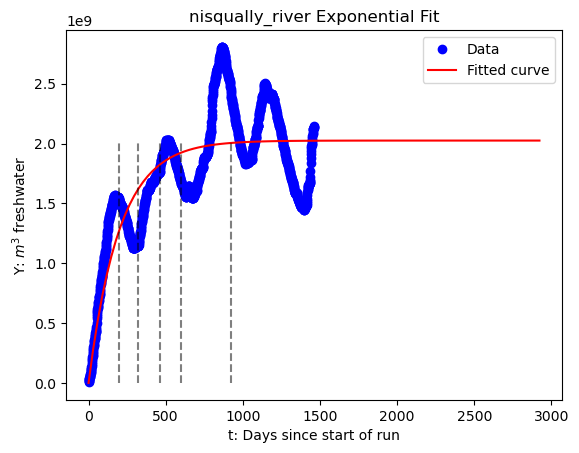

Optimized parameters:
A = 2082687885 m^3
T = 252 days, 0.69 years
T_80pct = 1.11 years
T_90pct = 1.59 years
T_95pct = 2.07 years
T_99pct = 3.18 years


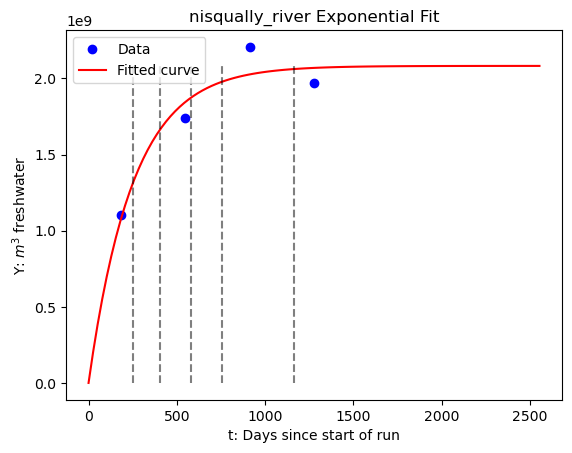

Optimized parameters:
A = 2208729150 m^3
T = 281 days, 0.77 years
T_80pct = 1.24 years
T_90pct = 1.77 years
T_95pct = 2.30 years
T_99pct = 3.54 years


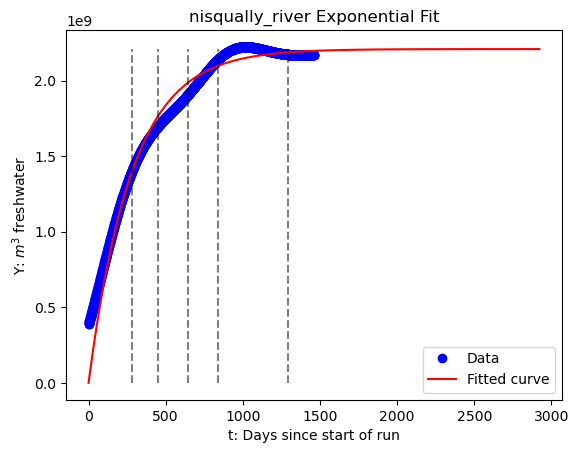

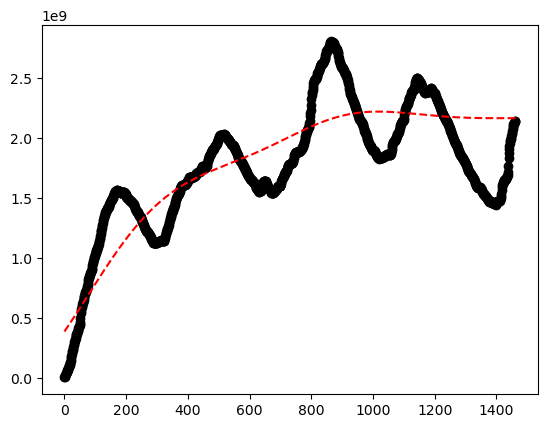

In [55]:
variable = 'nisqually_river'
days, vols = days_vols(idxs, fw_rivers_subset, nisqually_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nisqually_arr)), Y_data=nisqually_arr, region=variable)

chunk_size = 365
data_arr = nisqually_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, nisqually_arr)
A_opt_nisqually, T_opt_nisqually = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nisqually_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(nisqually_arr)), nisqually_arr, 'ko')
plt.plot(np.arange(0, len(nisqually_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 454297564 m^3
T = 158 days, 0.43 years
T_80pct = 0.70 years
T_90pct = 1.00 years
T_95pct = 1.29 years
T_99pct = 1.99 years


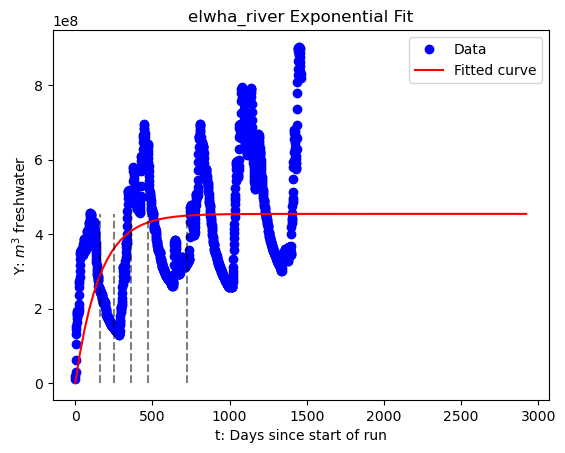

Optimized parameters:
A = 477082001 m^3
T = 222 days, 0.61 years
T_80pct = 0.98 years
T_90pct = 1.40 years
T_95pct = 1.82 years
T_99pct = 2.80 years


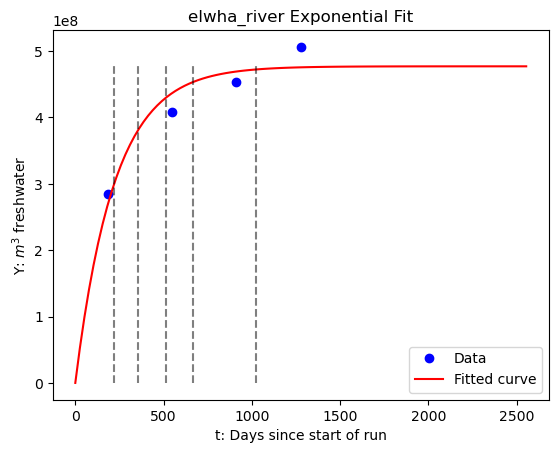

Optimized parameters:
A = 475744092 m^3
T = 221 days, 0.60 years
T_80pct = 0.97 years
T_90pct = 1.39 years
T_95pct = 1.81 years
T_99pct = 2.78 years


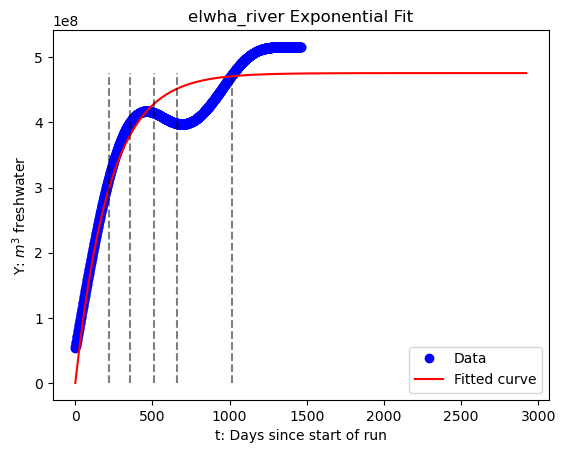

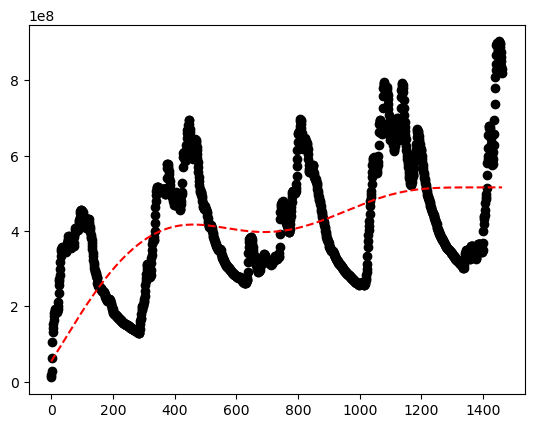

In [56]:
variable = 'elwha_river'
days, vols = days_vols(idxs, fw_rivers_subset, elwha_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(elwha_arr)), Y_data=elwha_arr, region=variable)

chunk_size = 365
data_arr = elwha_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, elwha_arr)
A_opt_elwha, T_opt_elwha = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(elwha_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(elwha_arr)), elwha_arr, 'ko')
plt.plot(np.arange(0, len(elwha_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 497006339 m^3
T = 176 days, 0.48 years
T_80pct = 0.77 years
T_90pct = 1.11 years
T_95pct = 1.44 years
T_99pct = 2.21 years


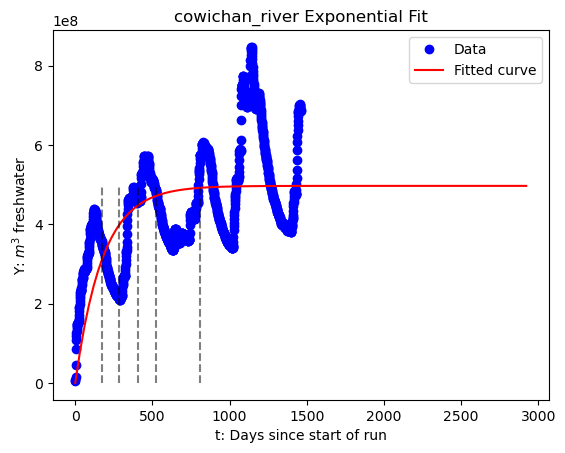

Optimized parameters:
A = 519185354 m^3
T = 239 days, 0.65 years
T_80pct = 1.05 years
T_90pct = 1.51 years
T_95pct = 1.96 years
T_99pct = 3.01 years


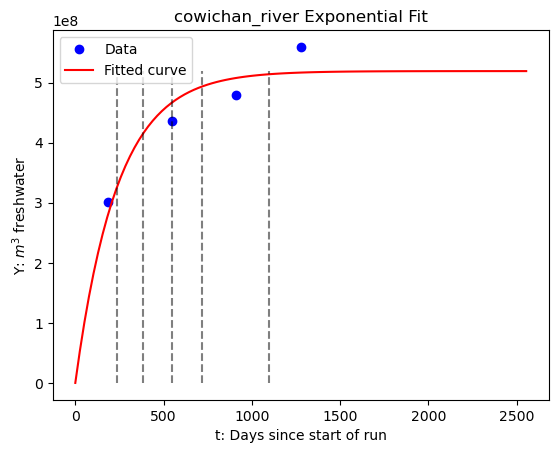

Optimized parameters:
A = 543507439 m^3
T = 276 days, 0.76 years
T_80pct = 1.22 years
T_90pct = 1.74 years
T_95pct = 2.27 years
T_99pct = 3.48 years


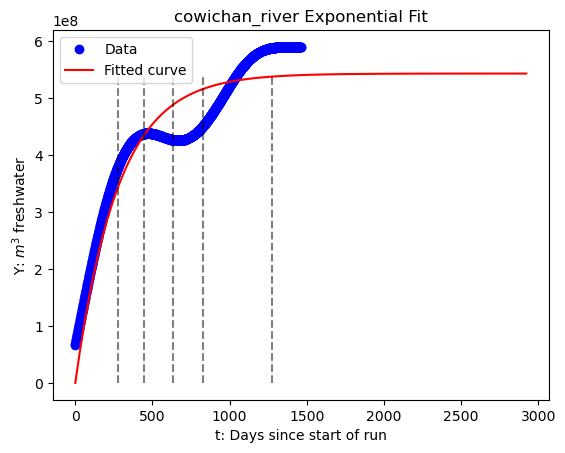

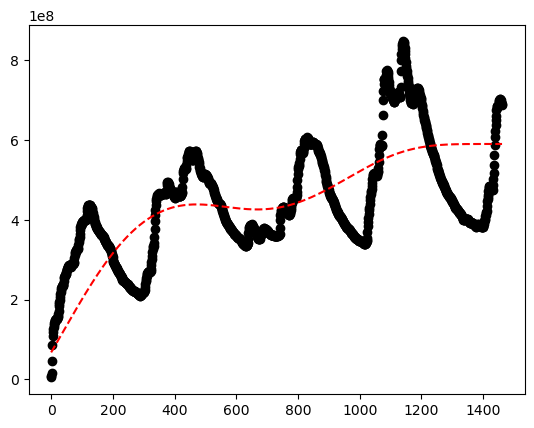

In [58]:
variable = 'cowichan_river'
days, vols = days_vols(idxs, fw_rivers_subset, cowichan_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(cowichan_arr)), Y_data=cowichan_arr, region=variable)

chunk_size = 365
data_arr = cowichan_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, cowichan_arr)
A_opt_cowichan, T_opt_cowichan = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(cowichan_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(cowichan_arr)), cowichan_arr, 'ko')
plt.plot(np.arange(0, len(cowichan_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 648719082 m^3
T = 234 days, 0.64 years
T_80pct = 1.03 years
T_90pct = 1.48 years
T_95pct = 1.92 years
T_99pct = 2.95 years


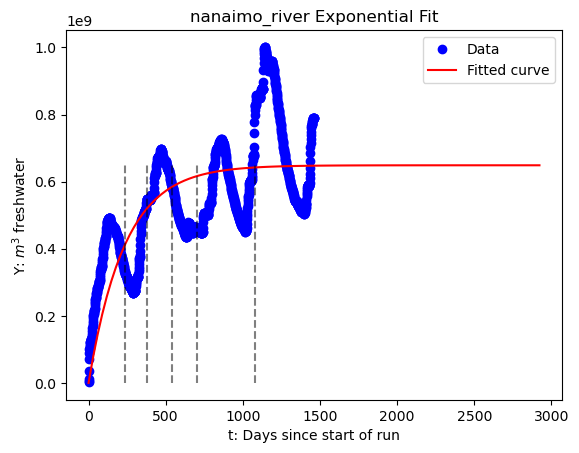

Optimized parameters:
A = 676931980 m^3
T = 293 days, 0.80 years
T_80pct = 1.29 years
T_90pct = 1.85 years
T_95pct = 2.41 years
T_99pct = 3.70 years


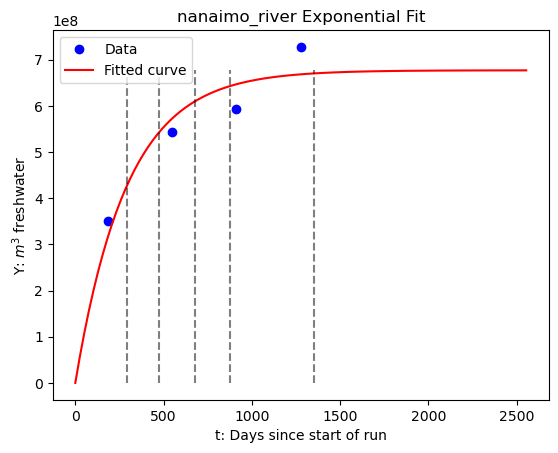

Optimized parameters:
A = 707617541 m^3
T = 329 days, 0.90 years
T_80pct = 1.45 years
T_90pct = 2.07 years
T_95pct = 2.70 years
T_99pct = 4.15 years


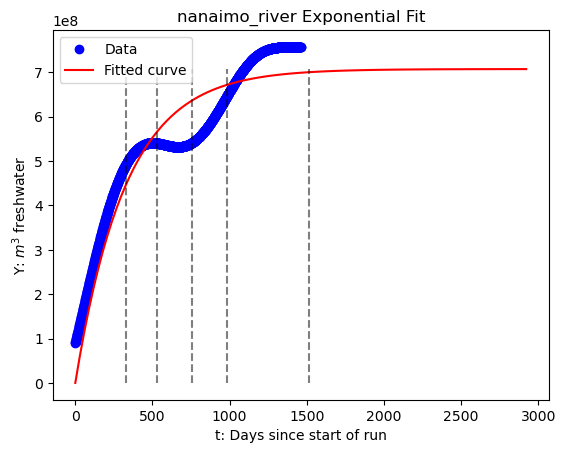

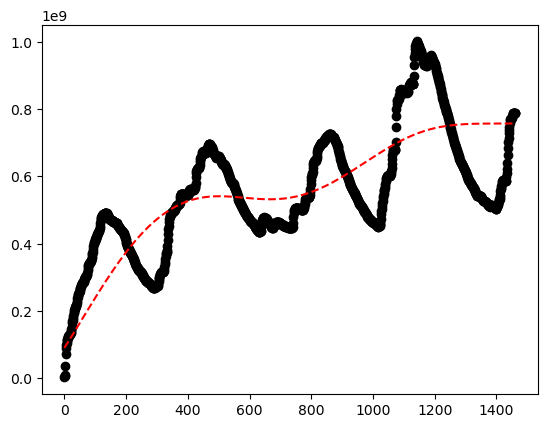

In [60]:
variable = 'nanaimo_river'
days, vols = days_vols(idxs, fw_rivers_subset, nanaimo_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nanaimo_arr)), Y_data=nanaimo_arr, region=variable)

chunk_size = 365
data_arr = nanaimo_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, nanaimo_arr)
A_opt_nanaimo, T_opt_nanaimo = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nanaimo_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(nanaimo_arr)), nanaimo_arr, 'ko')
plt.plot(np.arange(0, len(nanaimo_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 1166536299 m^3
T = 239 days, 0.65 years
T_80pct = 1.05 years
T_90pct = 1.51 years
T_95pct = 1.96 years
T_99pct = 3.01 years


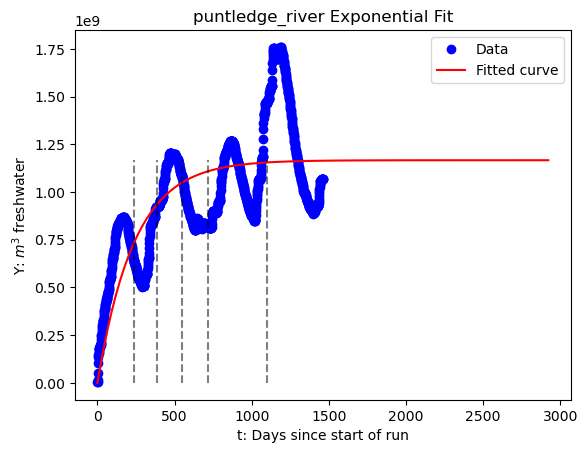

Optimized parameters:
A = 1217291651 m^3
T = 300 days, 0.82 years
T_80pct = 1.32 years
T_90pct = 1.89 years
T_95pct = 2.46 years
T_99pct = 3.78 years


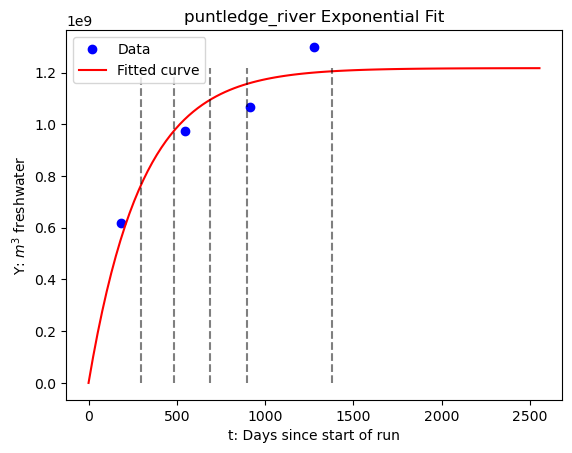

Optimized parameters:
A = 1300295519 m^3
T = 352 days, 0.97 years
T_80pct = 1.55 years
T_90pct = 2.22 years
T_95pct = 2.89 years
T_99pct = 4.45 years


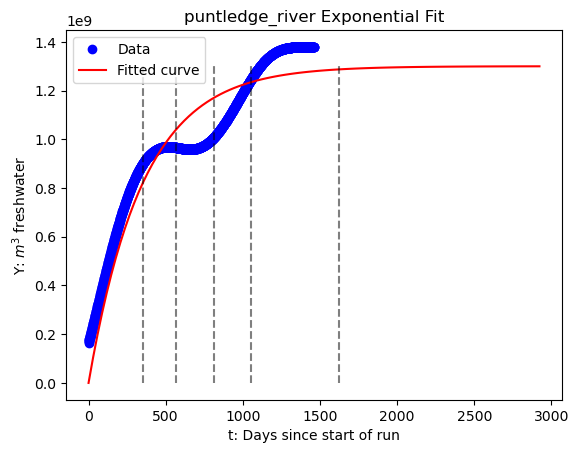

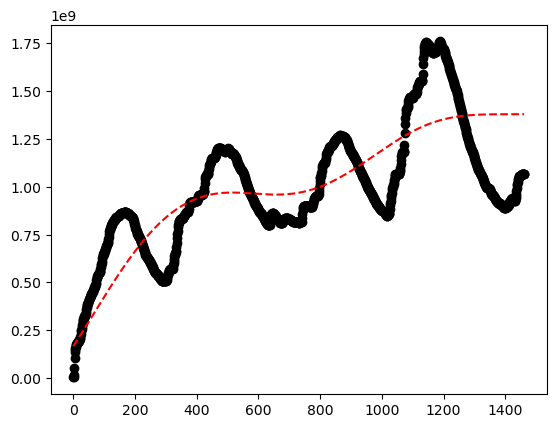

In [62]:
variable = 'puntledge_river'
days, vols = days_vols(idxs, fw_rivers_subset, puntledge_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(puntledge_arr)), Y_data=puntledge_arr, region=variable)

chunk_size = 365
data_arr = puntledge_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, puntledge_arr)
A_opt_puntledge, T_opt_puntledge = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(puntledge_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(puntledge_arr)), puntledge_arr, 'ko')
plt.plot(np.arange(0, len(puntledge_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 445390321 m^3
T = 252 days, 0.69 years
T_80pct = 1.11 years
T_90pct = 1.59 years
T_95pct = 2.07 years
T_99pct = 3.18 years


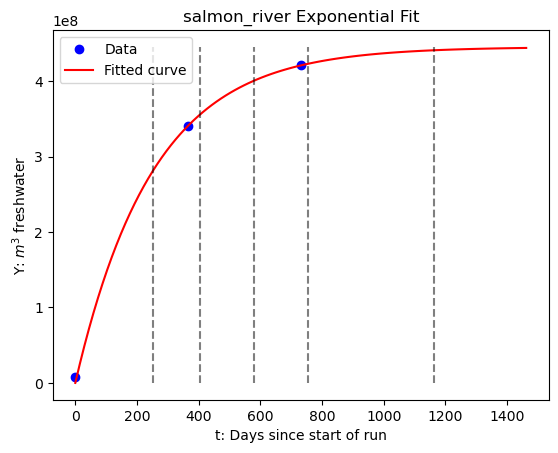

Optimized parameters:
A = 425327239 m^3
T = 147 days, 0.40 years
T_80pct = 0.65 years
T_90pct = 0.92 years
T_95pct = 1.20 years
T_99pct = 1.85 years


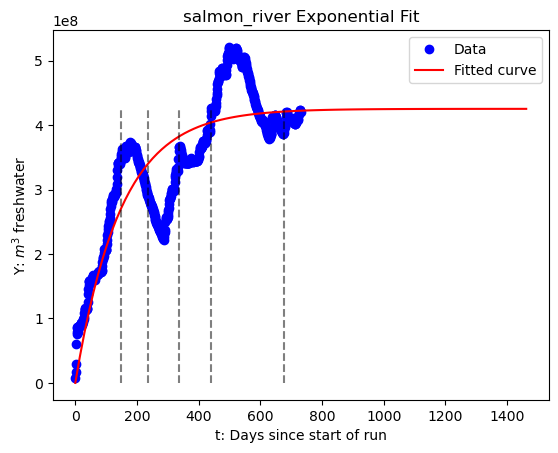

Optimized parameters:
A = 426970529 m^3
T = 157 days, 0.43 years
T_80pct = 0.69 years
T_90pct = 0.99 years
T_95pct = 1.29 years
T_99pct = 1.98 years


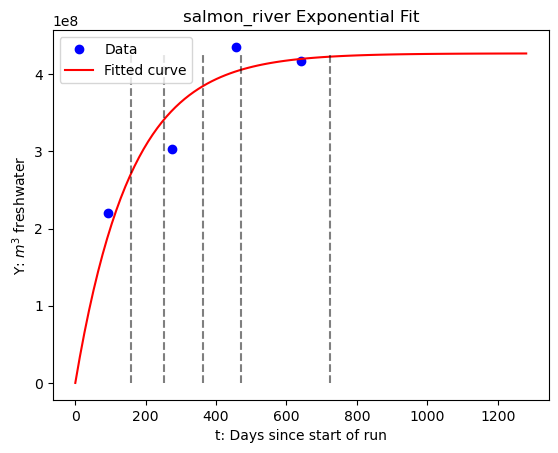

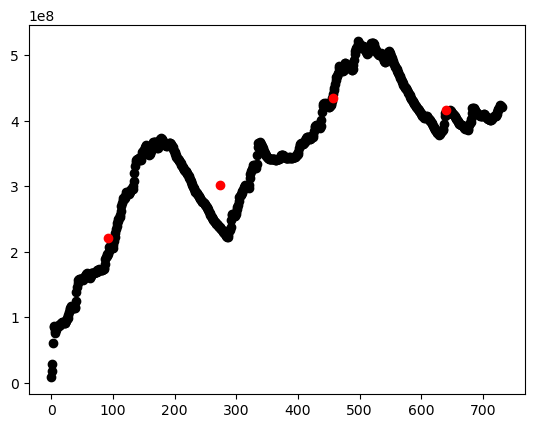

In [ ]:
variable = 'salmon_river'
days, vols = days_vols(idxs, fw_rivers_subset, salmon_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(salmon_arr)), Y_data=salmon_arr, region=variable)

chunk_size = 365
data_arr = salmon_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, salmon_arr)
A_opt_salmon, T_opt_salmon = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(salmon_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(salmon_arr)), salmon_arr, 'ko')
plt.plot(np.arange(0, len(salmon_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 11581142676 m^3
T = 465 days, 1.27 years
T_80pct = 2.05 years
T_90pct = 2.93 years
T_95pct = 3.81 years
T_99pct = 5.86 years


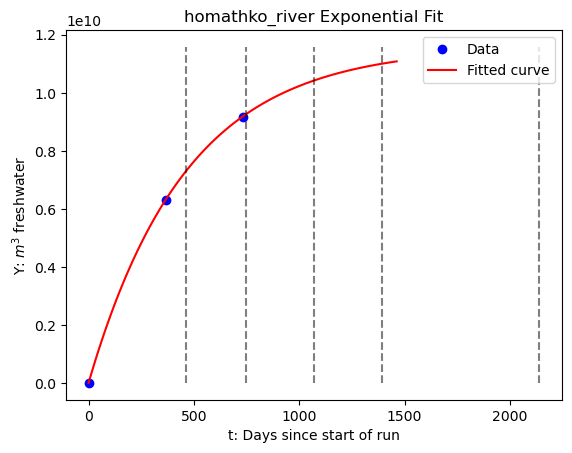

Optimized parameters:
A = 18652043440 m^3
T = 924 days, 2.53 years
T_80pct = 4.07 years
T_90pct = 5.83 years
T_95pct = 7.58 years
T_99pct = 11.66 years


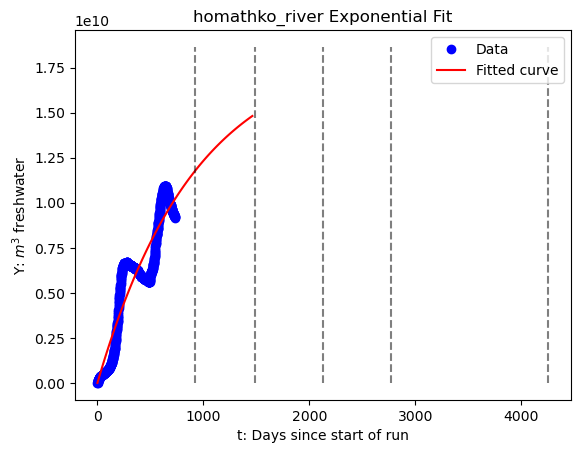

Optimized parameters:
A = 22155115879 m^3
T = 1153 days, 3.16 years
T_80pct = 5.08 years
T_90pct = 7.27 years
T_95pct = 9.46 years
T_99pct = 14.54 years


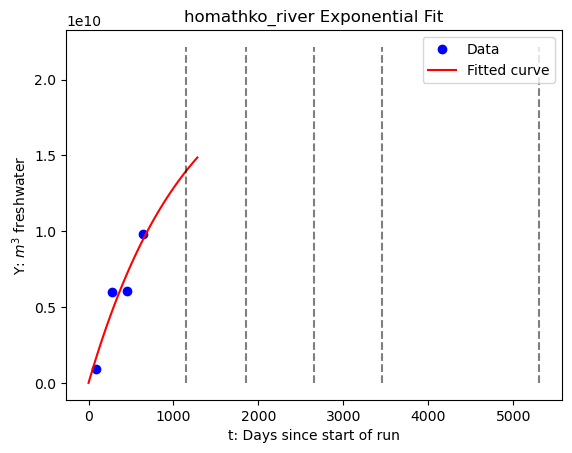

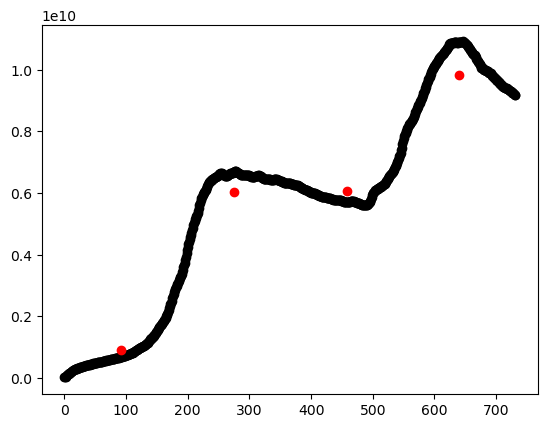

In [ ]:
variable = 'homathko_river'
days, vols = days_vols(idxs, fw_rivers_subset, homathko_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(homathko_arr)), Y_data=homathko_arr, region=variable)

chunk_size = 365
data_arr = homathko_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, homathko_arr)
A_opt_homathko, T_opt_homathko = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(homathko_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(homathko_arr)), homathko_arr, 'ko')
plt.plot(np.arange(0, len(homathko_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 7755036046 m^3
T = 308 days, 0.84 years
T_80pct = 1.36 years
T_90pct = 1.94 years
T_95pct = 2.52 years
T_99pct = 3.88 years


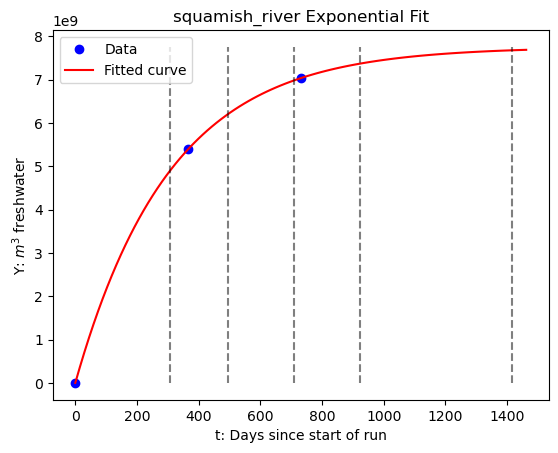

Optimized parameters:
A = 9966459389 m^3
T = 445 days, 1.22 years
T_80pct = 1.96 years
T_90pct = 2.81 years
T_95pct = 3.65 years
T_99pct = 5.61 years


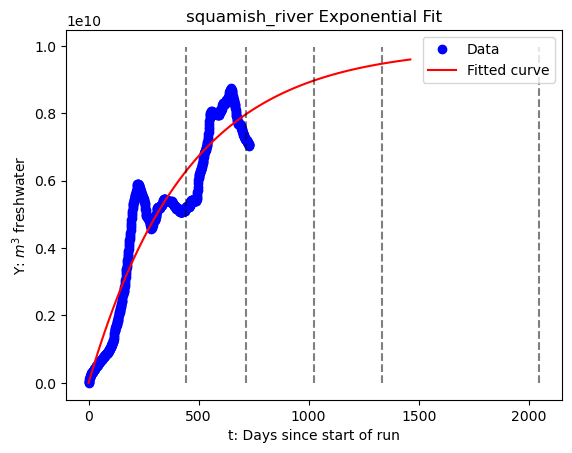

Optimized parameters:
A = 10839729797 m^3
T = 516 days, 1.41 years
T_80pct = 2.28 years
T_90pct = 3.26 years
T_95pct = 4.24 years
T_99pct = 6.51 years


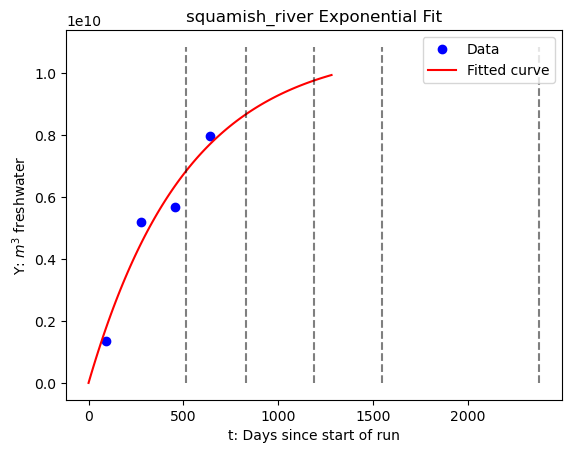

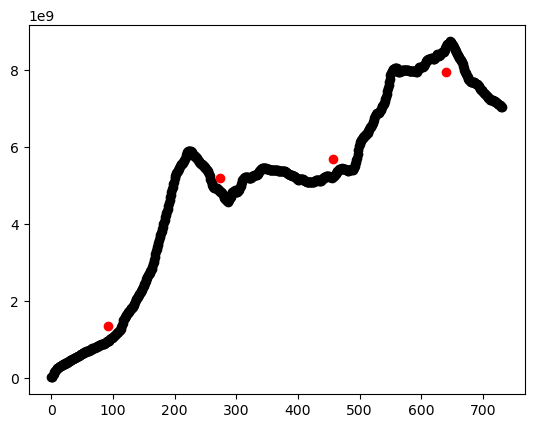

In [ ]:
variable = 'squamish_river'
days, vols = days_vols(idxs, fw_rivers_subset, squamish_arr)
# A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(squamish_arr)), Y_data=squamish_arr, region=variable)

chunk_size = 365
data_arr = squamish_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, squamish_arr)
A_opt_squamish, T_opt_squamish = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(squamish_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(squamish_arr)), squamish_arr, 'ko')
plt.plot(np.arange(0, len(squamish_arr)), filtered_signal, 'r--')

In [47]:
river_names = ['fraser', 'nooksack', 'skagit', 'snohomish', 'nisqually', 'elwha', 'cowichan', 'nanaimo', 'puntledge', 'salmon', 'homathko', 'squamish']
T_opt_list = [T_opt_fraser, T_opt_nooksack, T_opt_skagit, T_opt_snohomish, T_opt_nisqually, T_opt_elwha, T_opt_cowichan, T_opt_nanaimo, T_opt_puntledge, T_opt_salmon, T_opt_homathko, T_opt_squamish]
A_opt_list = [A_opt_fraser, A_opt_nooksack, A_opt_skagit, A_opt_snohomish, A_opt_nisqually, A_opt_elwha, A_opt_cowichan, A_opt_nanaimo, A_opt_puntledge, A_opt_salmon, A_opt_homathko, A_opt_squamish]

NameError: name 'T_opt_snohomish' is not defined

NameError: name 'river_names' is not defined

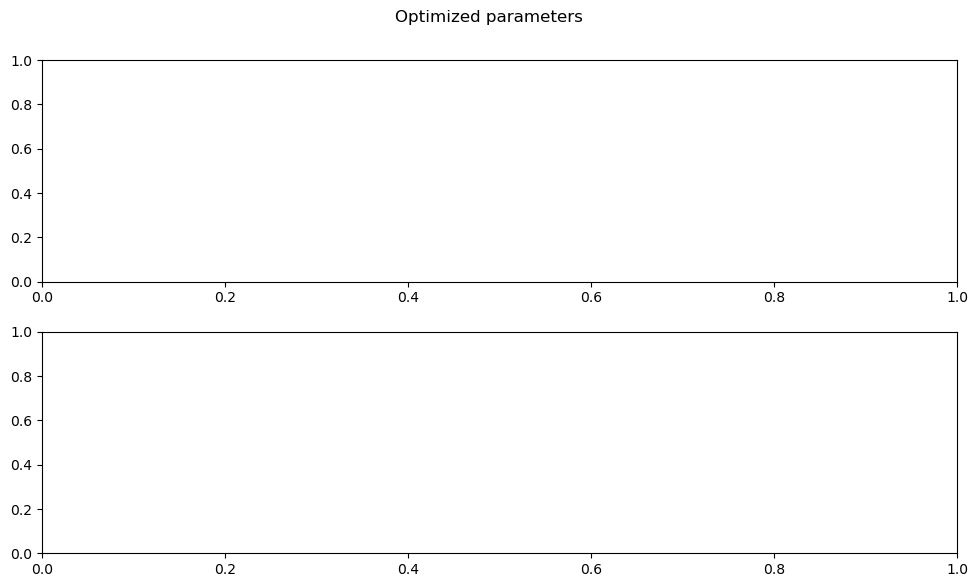

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
fig.suptitle('Optimized parameters')
fig.tight_layout(pad=1.5)

# ax[0].scatter(river_names, np.array(T_opt_list)/365)
ax[0].bar(river_names, np.array(T_opt_list)/365, facecolor=color3)
ax[0].set_ylabel('years')
ax[0].set_title('residence time')

# ax[1].scatter(river_names, A_opt_list)
ax[1].bar(river_names, A_opt_list)
ax[1].set_ylabel(r'$m^3$')
ax[1].set_title('steady state volume')